# Debug COG Filtering and PostGIS Intersection

This notebook helps debug the COG filtering methodology for western Ecuador boundary intersection.
We'll test database connections, COG URL retrieval, and spatial filtering step by step.

## Setup and Imports

In [1]:
import os
import sys
import psycopg2
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely import wkt
import requests
import json
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv('../../.env')

# Add the ml_pipeline src to path
sys.path.append('../src')
from ml_pipeline.extractor import TitilerExtractor

print("✅ Imports completed")
print("✅ Environment variables loaded from .env file")



✅ Imports completed
✅ Environment variables loaded from .env file


## Database Connection Testing

In [2]:
# Database connection parameters
# These will automatically pull from the .env file after load_dotenv() was called
DB_PARAMS = {
    'host': os.getenv('POSTGRES_HOST'),
    'port': os.getenv('POSTGRES_PORT'), 
    'database': os.getenv('POSTGRES_DBNAME'),
    'user': os.getenv('POSTGRES_USER'),
    'password': os.getenv('POSTGRES_PASS')
    }
print("Database connection parameters:")
for key, value in DB_PARAMS.items():
    if key == 'password':
        print(f"  {key}: {'*' * len(value) if value else 'empty'}")
    else:
        print(f"  {key}: {value}")
        
# Show which variables were loaded
print(f"\nEnvironment variables loaded:")
print(f"  POSTGRES_HOST: {os.getenv('POSTGRES_HOST', 'Not found')}")
print(f"  POSTGRES_USER: {os.getenv('POSTGRES_USER', 'Not found')}")
print(f"  POSTGRES_DBNAME: {os.getenv('POSTGRES_DBNAME', 'Not found')}")

Database connection parameters:
  host: db
  port: 5432
  database: cfwdb
  user: cfwuser
  password: ********************

Environment variables loaded:
  POSTGRES_HOST: db
  POSTGRES_USER: cfwuser
  POSTGRES_DBNAME: cfwdb


In [3]:
from ml_pipeline.db_utils import get_db_connection
engine = get_db_connection(host='remote')
engine.connect()
print("✅ Database connection established")

Getting DB connection...
Loading environment variables...
Creating database connection URL...
Creating engine...
✅ Database connection established
✅ Database connection established


In [12]:
# Connect to the database using SQLAlchemy
from sqlalchemy import text
from ml_pipeline.db_utils import get_db_connection

# Get database engine
engine = get_db_connection(host='remote')  # or 'localhost' for local DB

# Query using SQLAlchemy with pandas
query = text("""
    SELECT content->'assets'->'data'->>'href' as href
    FROM items
    WHERE collection = :collection
""")

# Execute query and get results as DataFrame
df = pd.read_sql(query, engine, params={"collection": "northern_choco_test_2025_06_20-pred-2022-04"})
print(df)
# Extract URLs
urls = df['href'].dropna().tolist()
print(f"Retrieved {len(urls)} COGs from database")

Getting DB connection...
Loading environment variables...
Creating database connection URL...
Creating engine...
                                                  href
0    s3://choco-forest-watch/predictions/northern_c...
1    s3://choco-forest-watch/predictions/northern_c...
2    s3://choco-forest-watch/predictions/northern_c...
3    s3://choco-forest-watch/predictions/northern_c...
4    s3://choco-forest-watch/predictions/northern_c...
..                                                 ...
478  s3://choco-forest-watch/predictions/northern_c...
479  s3://choco-forest-watch/predictions/northern_c...
480  s3://choco-forest-watch/predictions/northern_c...
481  s3://choco-forest-watch/predictions/northern_c...
482  s3://choco-forest-watch/predictions/northern_c...

[483 rows x 1 columns]
Retrieved 483 COGs from database
                                                  href
0    s3://choco-forest-watch/predictions/northern_c...
1    s3://choco-forest-watch/predictions/northern_c...
2    

## Explore STAC Collections and Items

In [13]:
# Connect and explore collections using SQLAlchemy
from sqlalchemy import text

# List all collections
collections_query = text("SELECT id, content->>'title' as title FROM collections ORDER BY id")
collections_df = pd.read_sql(collections_query, engine)

print("📋 Available collections:")
for _, row in collections_df.iterrows():
    print(f"  {row['id']}: {row['title']}")

print("\n" + "="*50)

# Count items per collection
print("📊 Items per collection:")
for _, row in collections_df.iterrows():
    col_id = row['id']
    count_query = text("SELECT COUNT(*) as count FROM items WHERE collection = :collection")
    count_df = pd.read_sql(count_query, engine, params={"collection": col_id})
    count = count_df.iloc[0]['count']
    print(f"  {col_id}: {count} items")

📋 Available collections:
  benchmarks-esa-landcover-2020: None
  benchmarks-hansen-tree-cover-2022: None
  benchmarks-jrc-forestcover-2020: None
  benchmarks-mapbiomes-2022: None
  benchmarks-palsar-2020: None
  benchmarks-wri-treecover-2020: None
  nicfi-2022-01: None
  nicfi-2022-02: None
  nicfi-2022-03: None
  nicfi-2022-04: None
  nicfi-2022-05: None
  nicfi-2022-06: None
  nicfi-2022-07: None
  nicfi-2022-08: None
  nicfi-2022-09: None
  nicfi-2022-10: None
  nicfi-2022-11: None
  nicfi-2022-12: None
  nicfi-pred-2022-01: None
  nicfi-pred-2022-02: None
  nicfi-pred-2022-03: None
  nicfi-pred-2022-04: None
  nicfi-pred-2022-05: None
  nicfi-pred-2022-06: None
  nicfi-pred-2022-07: None
  nicfi-pred-2022-08: None
  nicfi-pred-2022-10: None
  nicfi-pred-2022-11: None
  nicfi-pred-2022-12: None
  nicfi-pred-20250520T2122_rf_test_2022-composite-2022: None
  nicfi-pred-composite-2022: None
  nicfi-pred-northern_choco_test_2025_06_09-composite-2022: None
  nicfi-pred-northern_choco_tes

## Load Western Ecuador Boundary

✅ Loaded Ecuador boundary with 1 features
CRS: EPSG:4326
Bounds: [-81.01393955  -4.49135878 -78.25240924   1.44656863]
Combined boundary geometry type: MultiPolygon


/var/folders/q1/fbc54mrs7nb58w1zbcv8vqbw0000gn/T/ipykernel_96401/1412019930.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ecuador_polygon = ecuador_boundary.unary_union


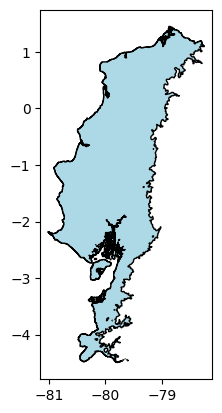

In [15]:
# Load the western Ecuador boundary shapefile
boundary_path = "boundaries/Ecuador-DEM-900m-contour.geojson"
if os.path.exists(boundary_path):
    ecuador_boundary = gpd.read_file(boundary_path)
    print(f"✅ Loaded Ecuador boundary with {len(ecuador_boundary)} features")
    print(f"CRS: {ecuador_boundary.crs}")
    print(f"Bounds: {ecuador_boundary.total_bounds}")
    
    # Convert to WGS84 if needed
    if ecuador_boundary.crs != 'EPSG:4326':
        ecuador_boundary = ecuador_boundary.to_crs('EPSG:4326')
        print(f"Converted to WGS84. New bounds: {ecuador_boundary.total_bounds}")
    
    # Get the unary union for easier intersection testing
    ecuador_polygon = ecuador_boundary.unary_union
    print(f"Combined boundary geometry type: {ecuador_polygon.geom_type}")
    
else:
    print(f"❌ Boundary file not found: {boundary_path}")
    ecuador_boundary = None
    ecuador_polygon = None


plot = ecuador_boundary.plot(color='lightblue', edgecolor='black')

## Test TitilerExtractor COG URL Retrieval

In [ ]:
# Initialize the extractor
extractor = TitilerExtractor(
    collection="northern_choco_test_2025_06_20-pred-2022-04",  # Adjust collection name
    band_indexes=[1, 2, 3, 4],  # NICFI bands
    db_host="remote"  # Use remote for notebooks connecting to external DB
)

print(f"✅ TitilerExtractor initialized")
print(f"Collection: {extractor.collection}")
print(f"DB Host: {extractor.db_host}")

In [17]:
# Test getting all COG URLs directly from database using SQLAlchemy
print("🔍 Testing direct database COG retrieval...")

# Check what collections we actually have
collections_query = text("SELECT DISTINCT collection FROM items LIMIT 10")
collections_df = pd.read_sql(collections_query, engine)
actual_collections = collections_df['collection'].tolist()

print(f"📋 Actual collections in database: {actual_collections}")

# Use the first available collection for testing
if actual_collections:
    test_collection = actual_collections[0]
    print(f"🧪 Using collection '{test_collection}' for testing")
    
    # Get sample items
    sample_query = text("""
        SELECT content->'assets'->'data'->>'href' as href,
               content->'geometry' as geom,
               content->'id' as item_id
        FROM items 
        WHERE collection = :collection 
        AND content->'assets'->'data' IS NOT NULL
        LIMIT 5
    """)
    
    sample_df = pd.read_sql(sample_query, engine, params={"collection": test_collection})
    
    print(f"\n📋 Sample items from {test_collection}:")
    for i, row in sample_df.iterrows():
        print(f"  {i+1}. ID: {row['item_id']}")
        print(f"     URL: {row['href'][:60]}...")
        if row['geom']:
            geom_obj = json.loads(json.dumps(row['geom']))
            print(f"     Geometry: {geom_obj.get('type', 'Unknown')}")
            if 'coordinates' in geom_obj:
                coords = geom_obj['coordinates']
                print(f"     Bounds sample: {coords[0] if coords else 'No coords'}")
        print()

🔍 Testing direct database COG retrieval...
📋 Actual collections in database: ['nicfi-pred-2022-02', 'northern_choco_test_2025_06_09-pred-2022-09', 'northern_choco_test_2025_06_09-pred-2022-01', 'northern_choco_test_2025_06_20-pred-2022-05', 'nicfi-pred-2022-10', 'nicfi-pred-2022-12', 'northern_choco_test_2025_06_09-pred-2022-02', 'northern_choco_test_2025_06_20-pred-2022-03', 'nicfi-2022-05', 'nicfi-pred-2022-04']
🧪 Using collection 'nicfi-pred-2022-02' for testing

📋 Sample items from nicfi-pred-2022-02:


In [44]:

# Connect to the database using SQLAlchemy
from sqlalchemy import text
from ml_pipeline.db_utils import get_db_connection

# Get database engine
engine = get_db_connection(host='remote')  # or 'localhost' for local DB





# Perform spatial intersection query with western Ecuador boundary
print("🗺️ Spatial intersection query for northern_choco_test_2025_06_20-pred-2022-04...")

# Collection to query
target_collection = "northern_choco_test_2025_06_20-pred-2022-04"

# Convert Ecuador polygon to WKT for the query
ecuador_wkt = ecuador_polygon.wkt

# Spatial intersection query using SQLAlchemy engine
spatial_query = text("""
    SELECT content->'assets'->'data'->>'href' as href,
           content->'id' as item_id,
           ST_AsGeoJSON(geometry) as geometry
    FROM items 
    WHERE collection = :collection
    AND ST_Intersects(geometry, ST_GeomFromText(:ecuador_wkt, 4326)) 

""")

try:
    # Execute query and get results as DataFrame
    intersecting_df = pd.read_sql(spatial_query, engine, params={
        "collection": target_collection, 
        "ecuador_wkt": ecuador_wkt
    })
    
    print(f"✅ Found {len(intersecting_df)} items intersecting Ecuador boundary")
    
    # Extract URLs and display first few results
    intersecting_urls = intersecting_df['href'].tolist()
    
    print(f"\n📋 First 5 intersecting items:")
    for i, row in intersecting_df.head().iterrows():
        print(f"  {i+1}. {row['item_id']}")
        print(f"     URL: {row['href'][:60]}...")
        print(f"     Geometry: {row['geometry']}...")
        # print(f"     Area: {row['geom_area']:.2e}")
        print()
    
    print(f"🎯 Total intersecting COG URLs: {len(intersecting_urls)}")

except Exception as e:
    print(f"❌ Spatial query failed: {e}")
    intersecting_urls = []
    intersecting_df = pd.DataFrame()


Getting DB connection...
Loading environment variables...
Creating database connection URL...
Creating engine...
🗺️ Spatial intersection query for northern_choco_test_2025_06_20-pred-2022-04...
❌ Spatial query failed: (psycopg2.errors.DiskFull) could not resize shared memory segment "/PostgreSQL.3961722182" to 307778368 bytes: No space left on device

[SQL: 
    SELECT content->'assets'->'data'->>'href' as href,
           content->'id' as item_id,
           ST_AsGeoJSON(geometry) as geometry
    FROM items 
    WHERE  ST_Intersects(geometry, ST_GeomFromText(%(ecuador_wkt)s, 4326)) 

]
[parameters: {'ecuador_wkt': 'MULTIPOLYGON (((-80.19157194188762 -3.437594115800719, -80.18954650678609 -3.437592391527629, -80.18752107270782 -3.4375906629411, -80.18549563965541 ... (955113 characters truncated) ... 81383438484266 1.426165418212517, -78.81181322773192 1.426163484644738, -78.80979207336549 1.426161549293638, -78.80979399587682 1.424127413474754)))'}]
(Background on this error at: https

In [ ]:
intersecting_df

,href,item_id,geometry
0,s3://choco-forest-watch/predictions/northern_c...,None,None
1,s3://choco-forest-watch/predictions/northern_c...,None,None
2,s3://choco-forest-watch/predictions/northern_c...,None,None
3,s3://choco-forest-watch/predictions/northern_c...,None,None
4,s3://choco-forest-watch/predictions/northern_c...,None,None
...,...,...,...
478,s3://choco-forest-watch/predictions/northern_c...,None,None
479,s3://choco-forest-watch/predictions/northern_c...,None,None
480,s3://choco-forest-watch/predictions/northern_c...,None,None
481,s3://choco-forest-watch/predictions/northern_c...,None,None


: 

## Test Spatial Intersection Queries

In [ ]:
# Test spatial intersection with western Ecuador boundary
if ecuador_polygon and actual_collections:
    print("🗺️ Testing spatial intersection with Ecuador boundary...")
    
    # Get Ecuador bounds for bbox query
    minx, miny, maxx, maxy = ecuador_boundary.total_bounds
    bbox_str = f"{minx},{miny},{maxx},{maxy}"
    print(f"Ecuador bbox: {bbox_str}")
    
    conn = psycopg2.connect(**DB_PARAMS)
    
    with conn.cursor() as cur:
        # Test 1: Simple bbox query (no spatial intersection)
        print("\n🧪 Test 1: Simple bbox intersection...")
        cur.execute("""
            SELECT COUNT(*)
            FROM items 
            WHERE collection = %s 
            AND content->'assets'->'data' IS NOT NULL
            AND content->'geometry' IS NOT NULL
        """, (test_collection,))
        total_with_geom = cur.fetchone()[0]
        print(f"Total items with geometry and assets: {total_with_geom}")
        
        # Test 2: Spatial intersection query
        print("\n🧪 Test 2: PostGIS spatial intersection...")
        
        # Convert Ecuador polygon to WKT for the query
        ecuador_wkt = ecuador_polygon.wkt
        
        try:
            spatial_query = """
                SELECT content->'assets'->'data'->>'href' as href,
                       content->'id' as item_id,
                       ST_Area(ST_GeomFromGeoJSON(content->'geometry')) as geom_area
                FROM items 
                WHERE collection = %s 
                AND content->'assets'->'data' IS NOT NULL
                AND content->'geometry' IS NOT NULL
                AND ST_Intersects(
                    ST_GeomFromGeoJSON(content->'geometry'),
                    ST_GeomFromText(%s, 4326)
                )
                LIMIT 10
            """
            
            cur.execute(spatial_query, (test_collection, ecuador_wkt))
            intersecting_items = cur.fetchall()
            
            print(f"✅ Found {len(intersecting_items)} items intersecting Ecuador boundary")
            
            for i, (href, item_id, area) in enumerate(intersecting_items[:3], 1):
                print(f"  {i}. {item_id}: {href[:50]}... (area: {area:.2e})")
                
        except Exception as e:
            print(f"❌ Spatial query failed: {e}")
            
            # Fallback: try with simpler bbox envelope
            print("\n🔄 Trying simpler bbox envelope query...")
            try:
                bbox_query = """
                    SELECT content->'assets'->'data'->>'href' as href,
                           content->'id' as item_id
                    FROM items 
                    WHERE collection = %s 
                    AND content->'assets'->'data' IS NOT NULL
                    AND content->'geometry' IS NOT NULL
                    AND ST_Intersects(
                        ST_GeomFromGeoJSON(content->'geometry'),
                        ST_MakeEnvelope(%s, %s, %s, %s, 4326)
                    )
                    LIMIT 10
                """
                
                cur.execute(bbox_query, (test_collection, minx, miny, maxx, maxy))
                bbox_items = cur.fetchall()
                
                print(f"✅ Bbox query found {len(bbox_items)} intersecting items")
                for i, (href, item_id) in enumerate(bbox_items[:3], 1):
                    print(f"  {i}. {item_id}: {href[:50]}...")
                    
            except Exception as e2:
                print(f"❌ Bbox query also failed: {e2}")
    
    conn.close()
    
else:
    print("⚠️ Skipping spatial tests - no boundary or collections available")

## Test Extractor Methods

In [ ]:
# Test the extractor's COG URL methods
if ecuador_polygon and actual_collections:
    print("🧪 Testing TitilerExtractor methods...")
    
    # Update extractor to use actual collection
    extractor.collection = test_collection
    
    # Test 1: Get COG URLs for Ecuador polygon
    print("\n🗺️ Test 1: get_cog_urls for Ecuador boundary...")
    try:
        cog_urls = extractor.get_cog_urls(ecuador_polygon, scan_limit=50)
        print(f"✅ Retrieved {len(cog_urls)} COG URLs")
        
        for i, url in enumerate(cog_urls[:3], 1):
            print(f"  {i}. {url}")
            
    except Exception as e:
        print(f"❌ get_cog_urls failed: {e}")
    
    # Test 2: Get all COG URLs with bbox
    print("\n🌍 Test 2: get_all_cog_urls with Ecuador bbox...")
    try:
        bbox_str = f"{minx},{miny},{maxx},{maxy}"
        all_cog_urls = extractor.get_all_cog_urls(
            collection=test_collection, 
            bbox=bbox_str, 
            scan_limit=50
        )
        print(f"✅ Retrieved {len(all_cog_urls)} COG URLs with bbox")
        
        for i, url in enumerate(all_cog_urls[:3], 1):
            print(f"  {i}. {url}")
            
    except Exception as e:
        print(f"❌ get_all_cog_urls with bbox failed: {e}")
    
    # Test 3: Database method directly
    print("\n💾 Test 3: Direct database COG URL retrieval...")
    try:
        db_cog_urls = extractor._get_cog_urls_from_db_with_bbox(
            test_collection, bbox_str, 50
        )
        print(f"✅ Retrieved {len(db_cog_urls)} COG URLs from database")
        
        for i, url in enumerate(db_cog_urls[:3], 1):
            print(f"  {i}. {url}")
            
    except Exception as e:
        print(f"❌ Database method failed: {e}")

else:
    print("⚠️ Skipping extractor tests - no boundary or collections available")

## Performance Comparison

In [ ]:
# Compare performance of different methods
import time

if ecuador_polygon and actual_collections:
    print("⏱️ Performance comparison of COG retrieval methods...")
    
    methods_to_test = [
        ("API get_cog_urls", lambda: extractor.get_cog_urls(ecuador_polygon, scan_limit=100)),
        ("API get_all_cog_urls with bbox", lambda: extractor.get_all_cog_urls(bbox=bbox_str, scan_limit=100)),
        ("Direct DB with bbox", lambda: extractor._get_cog_urls_from_db_with_bbox(test_collection, bbox_str, 100))
    ]
    
    results = {}
    
    for method_name, method_func in methods_to_test:
        print(f"\n🧪 Testing {method_name}...")
        try:
            start_time = time.time()
            urls = method_func()
            end_time = time.time()
            
            duration = end_time - start_time
            results[method_name] = {
                'duration': duration,
                'url_count': len(urls),
                'success': True
            }
            
            print(f"  ✅ {len(urls)} URLs in {duration:.2f}s")
            
        except Exception as e:
            results[method_name] = {
                'duration': None,
                'url_count': 0,
                'success': False,
                'error': str(e)
            }
            print(f"  ❌ Failed: {e}")
    
    # Summary
    print("\n📊 Performance Summary:")
    print("-" * 60)
    for method, result in results.items():
        if result['success']:
            print(f"{method:25} | {result['url_count']:4d} URLs | {result['duration']:6.2f}s")
        else:
            print(f"{method:25} | FAILED")

else:
    print("⚠️ Skipping performance tests - no boundary or collections available")

## Summary and Recommendations

In [ ]:
print("📋 DEBUGGING SUMMARY")
print("=" * 50)

if 'results' in locals():
    successful_methods = [m for m, r in results.items() if r['success']]
    if successful_methods:
        fastest_method = min(successful_methods, key=lambda m: results[m]['duration'])
        print(f"✅ Fastest method: {fastest_method}")
        print(f"   Duration: {results[fastest_method]['duration']:.2f}s")
        print(f"   URLs found: {results[fastest_method]['url_count']}")
    else:
        print("❌ No methods worked successfully")
else:
    print("⚠️ No performance tests were run")

print("\n🎯 RECOMMENDATIONS:")
print("1. Use direct database queries for better performance")
print("2. Ensure PostGIS spatial indexes are properly configured")
print("3. Consider caching COG URLs for repeated queries")
print("4. Test with larger scan_limit values for production use")
print("5. Implement retry logic for failed API calls")

print("\n✨ Next steps:")
print("- Optimize the spatial intersection queries")
print("- Add proper error handling and logging")
print("- Consider using spatial indexing for better performance")
print("- Test with real polygon training data")